# ****Speech Recognition Using CNN****

In [ ]:
import pandas as pd
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow as tf
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle


In [ ]:
! cp kaggle.json ~/.kaggle/


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle competitions download tensorflow-speech-recognition-challenge

 99% 2.45G/2.46G [00:32<00:00, 59.2MB/s]
100% 2.46G/2.46G [00:32<00:00, 80.2MB/s]
100% 1.04G/1.04G [00:23<00:00, 35.4MB/s]
100% 1.04G/1.04G [00:23<00:00, 48.1MB/s]
  0% 0.00/50.0 [00:00<?, ?B/s]
100% 50.0/50.0 [00:00<00:00, 52.3kB/s]
  0% 0.00/501k [00:00<?, ?B/s]
100% 501k/501k [00:00<00:00, 70.1MB/s]


In [ ]:
!unzip train.7z

Archive:  train.7z
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train.7z or
        train.7z.zip, and cannot find train.7z.ZIP, period.


In [ ]:
!apt install p7zip-ful

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package p7zip-ful


In [ ]:
!7z x train.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                            0% 41 - train/audio/_background_noise_/pink_noise.wav                                                         0% 54 - train/audio/bed/014f9f65_nohash_0.wav

In [ ]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [ ]:
train_audio_path="/content/train/audio"

Text(0.5, 0, 'Seconds')

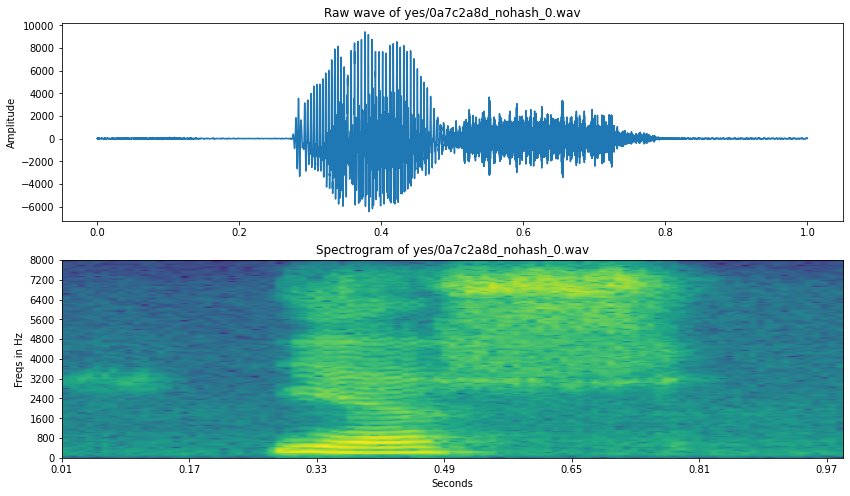

In [ ]:
train_audio_path = 'train/audio/'
filename = 'yes/0a7c2a8d_nohash_0.wav'
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [ ]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
%matplotlib inline

# and IPython.display for audio output
import IPython.display

# Librosa for audio
import librosa
# And the display module for visualization
import librosa.display

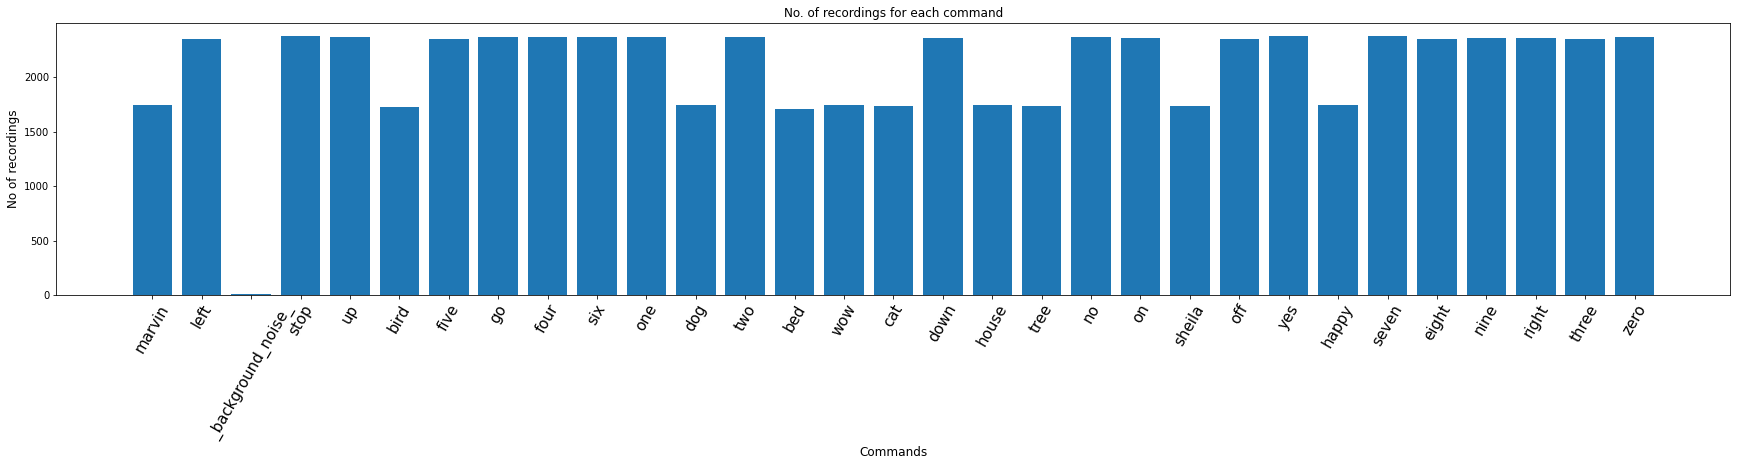

In [ ]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()


In [ ]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]


(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <a list of 10 Patch objects>)

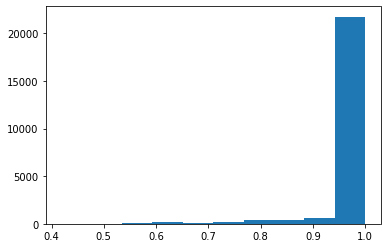

In [ ]:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [ ]:
train_audio_path = 'train/audio/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)
classes

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']

In [ ]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))


In [ ]:
y

In [ ]:
all_wave = np.array(all_wave).reshape(-1,8000,1)
all_wave.shape


(21312, 8000, 1)

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)


In [ ]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.2)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.2)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.2)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.00001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')


In [ ]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))


Epoch 1/100
533/533 [==============================] - 20s 20ms/step - loss: 2.3008 - accuracy: 0.1093 - val_loss: 2.2985 - val_accuracy: 0.1356
Epoch 2/100
533/533 [==============================] - 10s 18ms/step - loss: 2.2946 - accuracy: 0.1277 - val_loss: 2.2921 - val_accuracy: 0.1346
Epoch 3/100
533/533 [==============================] - 10s 18ms/step - loss: 2.2842 - accuracy: 0.1341 - val_loss: 2.2805 - val_accuracy: 0.1522
Epoch 4/100
533/533 [==============================] - 10s 18ms/step - loss: 2.2692 - accuracy: 0.1414 - val_loss: 2.2624 - val_accuracy: 0.1504
Epoch 5/100
533/533 [==============================] - 10s 18ms/step - loss: 2.2498 - accuracy: 0.1534 - val_loss: 2.2309 - val_accuracy: 0.1783
Epoch 6/100
533/533 [==============================] - 10s 18ms/step - loss: 2.2106 - accuracy: 0.1711 - val_loss: 2.1754 - val_accuracy: 0.2043
Epoch 7/100
533/533 [==============================] - 10s 19ms/step - loss: 2.1635 - accuracy: 0.1933 - val_loss: 2.1193 - val_ac

In [ ]:
model.save_weights()

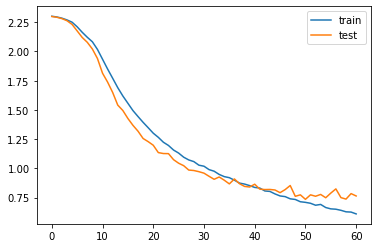

In [ ]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend()
pyplot.show()

In [ ]:
def predict(audio):
    prob=model.predict(audio.reshape(1,len(audio),1))
    index=np.argmax(prob[0])
    return classes[index]

In [ ]:
import IPython.display as ipd
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))


Audio: down
Text: down


In [ ]:
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=1.07):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb') as f:
    f.write(b)
  return 'audio.wav'  # or webm ?

In [ ]:
voice=record()
s,sr=librosa.load(voice,16000)

predict(librosa.resample(s,sr,8000)[:8000])